In [4]:
import pandas as pd

In [5]:
#load data
# segment = 'NTC'
# X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')

In [9]:
def cb_model_builder2( depth = 6,
                     learning_rate = 0.03,
                     iterations =1000,
                     l2_leaf_reg = 3.0,
                     border_count = 50,
                     bagging_temperature = 1,
                     random_strength = 1,
                     od_wait = 10,
                     auto_class_weights = "Balanced",
                     random_state = 42,
                     objective = 'Logloss',
                     cat_features = cat_features
                    ):
    
    from catboost import CatBoostClassifier
    #catboost implementation
    model = CatBoostClassifier(depth = depth,
                     learning_rate = learning_rate,
                     iterations =iterations,
                     l2_leaf_reg = l2_leaf_reg,
                     border_count = border_count,
                     bagging_temperature = bagging_temperature,
                     random_strength = random_strength,
                     od_wait = od_wait,
                     auto_class_weights = auto_class_weights,
                     random_state = random_state,
                     objective = objective,
                     cat_features = cat_features)
    
    return model

In [10]:
def CB_model_auc(cleaned_df, catboost_model, segment):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    from sklearn.model_selection import (train_test_split, GridSearchCV)
    from sklearn.preprocessing import OneHotEncoder
    from catboost import CatBoostClassifier, Pool

    from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
    from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
    from catboost.utils import get_confusion_matrix, get_roc_curve, get_fnr_curve, get_fpr_curve
    from sklearn.metrics import RocCurveDisplay
    from sklearn import metrics

    from sklearn.model_selection import RandomizedSearchCV
    
    y = 'D3_within12months'
    X = cleaned_df.drop(columns = [y, 'loan_account_no'])
    y = cleaned_df[y]

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 11, train_size = 0.8,
                                                        test_size = 0.2, stratify = y)

    cat_features = X_train.select_dtypes(include=['object','category']).columns.tolist()

    # train_data = Pool(data=X_train,
    #              label = y_train,
    #              cat_features=cat_features)

    model = catboost_model

    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:,1]

    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_proba)
    
    #compute optimal threshold based on roc_auc curve only
    opt = true_positive_rate - false_positive_rate
    tp_fp_diff = pd.DataFrame({'thresholds': threshold, 'tpr_fpr': opt})

    max_index = tp_fp_diff.tpr_fpr.argmax()
    THRESHOLD = tp_fp_diff.iloc[max_index][0]
    
    y_pred = np.where(y_pred_proba > THRESHOLD, 1, 0)

    plt.subplots(1, figsize = (5,5))
    luh = roc_auc_score(y_test, y_pred_proba)
    plt.title(f'ROC_AUC Curve: {luh:.2f}')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0,1], ls = "--")
    plt.plot([0,0],[1,0], c= ".7"), plt.plot([1,1], c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    print(classification_report(y_test, y_pred, target_names = ['Good Customer','Bad Customer']))
    cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(cnf_matrix)
    print(tn, fp, fn, tp)
    
    sns.distplot(y_pred_proba)
    plt.show()

    feat_importances = model.feature_importances_
    feature_names = model.feature_names_

    feat_imp_df = pd.DataFrame({
        'variable':feature_names,
        'feature_importances':feat_importances
    })
    
    feat_imp_df.to_csv(f'./Feature_Importance/featimportance_CB_{segment}.csv', index=False)

    feat_imp_df = feat_imp_df.sort_values(by='feature_importances', ascending=False)
    print(feat_imp_df[:20])

0:	learn: 0.6881232	total: 221ms	remaining: 1m 10s
1:	learn: 0.6816933	total: 325ms	remaining: 51.4s
2:	learn: 0.6762746	total: 426ms	remaining: 44.9s
3:	learn: 0.6718581	total: 513ms	remaining: 40.4s
4:	learn: 0.6674340	total: 637ms	remaining: 40s
5:	learn: 0.6641861	total: 751ms	remaining: 39.2s
6:	learn: 0.6607948	total: 871ms	remaining: 38.8s
7:	learn: 0.6586520	total: 955ms	remaining: 37.1s
8:	learn: 0.6555933	total: 1.06s	remaining: 36.4s
9:	learn: 0.6540603	total: 1.16s	remaining: 36s
10:	learn: 0.6527552	total: 1.22s	remaining: 34.2s
11:	learn: 0.6513924	total: 1.32s	remaining: 33.9s
12:	learn: 0.6491132	total: 1.43s	remaining: 33.7s
13:	learn: 0.6480053	total: 1.52s	remaining: 33.2s
14:	learn: 0.6473867	total: 1.63s	remaining: 33.1s
15:	learn: 0.6458539	total: 1.74s	remaining: 33s
16:	learn: 0.6450676	total: 1.82s	remaining: 32.3s
17:	learn: 0.6447072	total: 1.88s	remaining: 31.4s
18:	learn: 0.6433383	total: 1.97s	remaining: 31.1s
19:	learn: 0.6417896	total: 2.07s	remaining: 3

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_16076\1404315374.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


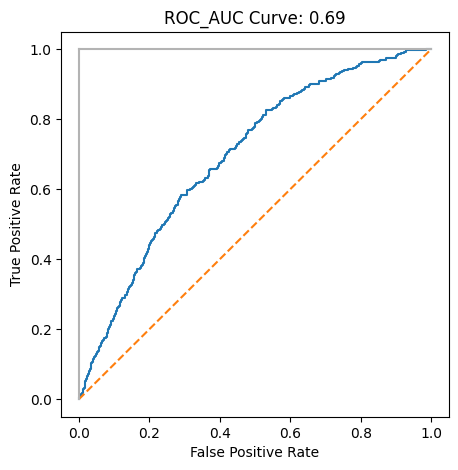

               precision    recall  f1-score   support

Good Customer       0.96      0.47      0.63      3492
 Bad Customer       0.13      0.82      0.22       338

     accuracy                           0.50      3830
    macro avg       0.55      0.65      0.43      3830
 weighted avg       0.89      0.50      0.59      3830

[[1635 1857]
 [  60  278]]
1635 1857 60 278


C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_16076\1404315374.py:66: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


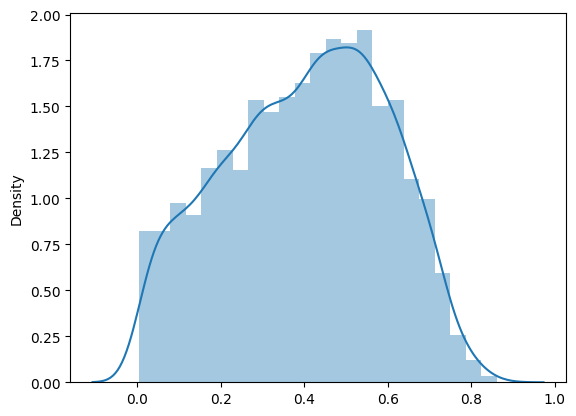

                        variable  feature_importances
3            down_payment_amount            12.081463
8                loan_asset_cost             9.190724
15                      dp_ratio             9.168557
2                            age             9.135262
19                    branch_grp             8.609529
6                  interest_rate             6.798579
7         number_of_installments             6.260457
9   res_years_at_current_address             4.956523
1      res_years_at_current_city             4.883777
14                monthly_income             4.212322
22                 res_state_grp             3.973468
21                  res_city_grp             3.419665
4                   total_income             2.652103
20               asset_model_grp             2.345530
12            nature_of_business             2.130393
13           years_in_occupation             2.057400
5                occupation_type             1.645159
23       res_resident_status

In [13]:
#NTC_level: tuned
#cat_features = X_train.select_dtypes(include=['object','category']).columns.tolist()
cat_features = ['product_description', 'marital_status', 'occupation_type','industry_grp',
                'res_city_grp','res_state_grp','res_resident_status_grp','branch_grp',
                'manufacturer_grp', 'gender','nature_of_business','channel_grp','asset_model_grp']
cbc_ntc_vf = cb_model_builder2( depth = 4,
                     learning_rate = 0.0979722306417506,
                     iterations =319,
                     l2_leaf_reg = 10.909079937846313,
                     border_count = 233,
                     bagging_temperature = 1.349262400109297,
                     random_strength = 1.959828624191452,
                     od_wait = 87,
                     auto_class_weights = "Balanced",
                     random_state = 42,
                     objective = 'Logloss',
                     cat_features = cat_features
                    )
segment = 'NTC'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
CB_model_auc(X, cbc_ntc_vf, segment)

0:	learn: 0.6924458	total: 154ms	remaining: 31.5s
1:	learn: 0.6916862	total: 214ms	remaining: 21.9s
2:	learn: 0.6916465	total: 271ms	remaining: 18.4s
3:	learn: 0.6913420	total: 369ms	remaining: 18.6s
4:	learn: 0.6909136	total: 495ms	remaining: 19.9s
5:	learn: 0.6906577	total: 610ms	remaining: 20.3s
6:	learn: 0.6900940	total: 848ms	remaining: 24.1s
7:	learn: 0.6898240	total: 995ms	remaining: 24.6s
8:	learn: 0.6888396	total: 1.22s	remaining: 26.8s
9:	learn: 0.6880519	total: 1.43s	remaining: 28s
10:	learn: 0.6876534	total: 1.49s	remaining: 26.4s
11:	learn: 0.6874557	total: 1.57s	remaining: 25.3s
12:	learn: 0.6867604	total: 1.67s	remaining: 24.8s
13:	learn: 0.6860905	total: 1.73s	remaining: 23.7s
14:	learn: 0.6858704	total: 1.83s	remaining: 23.3s
15:	learn: 0.6857332	total: 1.89s	remaining: 22.4s
16:	learn: 0.6847134	total: 2.12s	remaining: 23.6s
17:	learn: 0.6844177	total: 2.21s	remaining: 23.1s
18:	learn: 0.6840275	total: 2.29s	remaining: 22.6s
19:	learn: 0.6837533	total: 2.48s	remaining

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_16076\1404315374.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


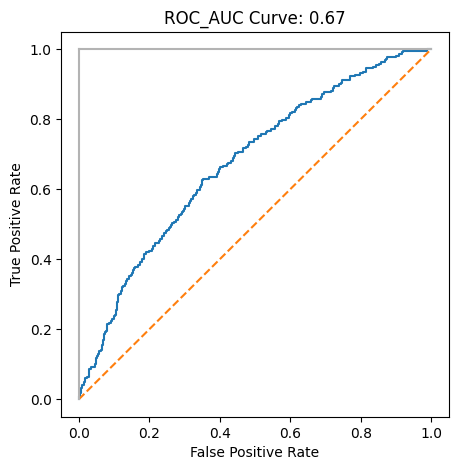

               precision    recall  f1-score   support

Good Customer       0.94      0.65      0.77      2177
 Bad Customer       0.15      0.63      0.24       219

     accuracy                           0.64      2396
    macro avg       0.55      0.64      0.51      2396
 weighted avg       0.87      0.64      0.72      2396

[[1407  770]
 [  82  137]]
1407 770 82 137


C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_16076\1404315374.py:66: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


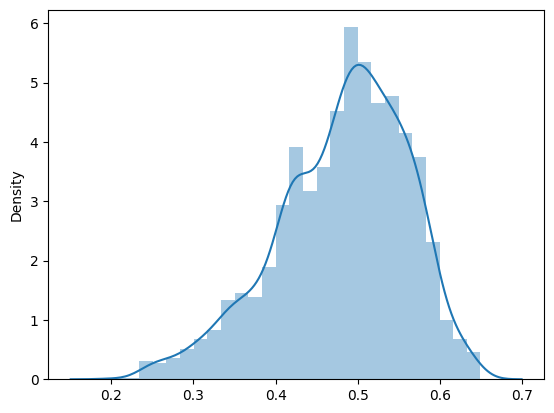

                        variable  feature_importances
7         number_of_installments            17.912753
19                    branch_grp            16.554377
15                      dp_ratio            10.171212
2                            age             8.921554
22                 res_state_grp             7.267190
3            down_payment_amount             6.358555
21                  res_city_grp             3.947874
18                  industry_grp             3.367191
5                occupation_type             3.202941
23       res_resident_status_grp             2.818223
11                marital_status             2.702209
16              manufacturer_grp             2.587745
20               asset_model_grp             2.344839
6                  interest_rate             1.799838
12            nature_of_business             1.667056
1      res_years_at_current_city             1.660938
9   res_years_at_current_address             1.577196
0            product_descrip

In [14]:
#low_CIBIL_level: tuned
cat_features = ['product_description', 'marital_status', 'occupation_type','industry_grp',
                'res_city_grp','res_state_grp','res_resident_status_grp','branch_grp',
                'manufacturer_grp', 'gender','nature_of_business','channel_grp','asset_model_grp']
cbc_low_CIBIL_vf = cb_model_builder2( depth = 9,
                     learning_rate = 0.022375193103931247,
                     iterations =206,
                     l2_leaf_reg = 12.032954711310595,
                     border_count = 155,
                     bagging_temperature = 0.8428035290621423,
                     random_strength = 4.234014807063696,
                     od_wait = 80,
                     auto_class_weights = "Balanced",
                     random_state = 42,
                     objective = 'Logloss',
                     cat_features = cat_features
                    )
segment = 'low_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
CB_model_auc(X, cbc_low_CIBIL_vf, segment)

0:	learn: 0.6926986	total: 45.4ms	remaining: 9.31s
1:	learn: 0.6923825	total: 83.1ms	remaining: 8.47s
2:	learn: 0.6923825	total: 125ms	remaining: 8.45s
3:	learn: 0.6915523	total: 205ms	remaining: 10.4s
4:	learn: 0.6904390	total: 372ms	remaining: 14.9s
5:	learn: 0.6890992	total: 565ms	remaining: 18.8s
6:	learn: 0.6886380	total: 653ms	remaining: 18.6s
7:	learn: 0.6883709	total: 691ms	remaining: 17.1s
8:	learn: 0.6879428	total: 747ms	remaining: 16.3s
9:	learn: 0.6878623	total: 788ms	remaining: 15.4s
10:	learn: 0.6875098	total: 863ms	remaining: 15.3s
11:	learn: 0.6868646	total: 1.07s	remaining: 17.4s
12:	learn: 0.6864296	total: 1.16s	remaining: 17.3s
13:	learn: 0.6856877	total: 1.42s	remaining: 19.4s
14:	learn: 0.6844779	total: 1.57s	remaining: 19.9s
15:	learn: 0.6833460	total: 1.77s	remaining: 21s
16:	learn: 0.6823651	total: 1.97s	remaining: 21.9s
17:	learn: 0.6815389	total: 2.12s	remaining: 22.2s
18:	learn: 0.6813243	total: 2.19s	remaining: 21.6s
19:	learn: 0.6802344	total: 2.35s	remaini

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_16076\1404315374.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


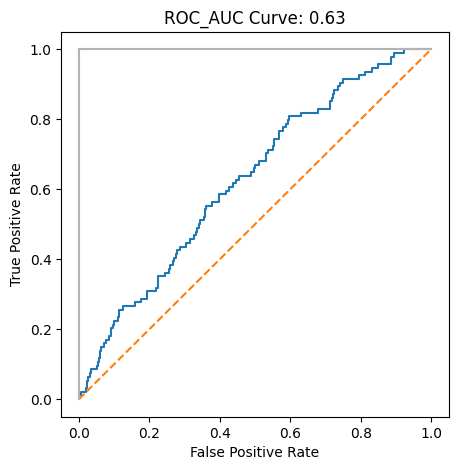

               precision    recall  f1-score   support

Good Customer       0.97      0.40      0.57      1475
 Bad Customer       0.08      0.80      0.14        94

     accuracy                           0.43      1569
    macro avg       0.52      0.60      0.36      1569
 weighted avg       0.92      0.43      0.54      1569

[[596 879]
 [ 19  75]]
596 879 19 75


C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_16076\1404315374.py:66: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


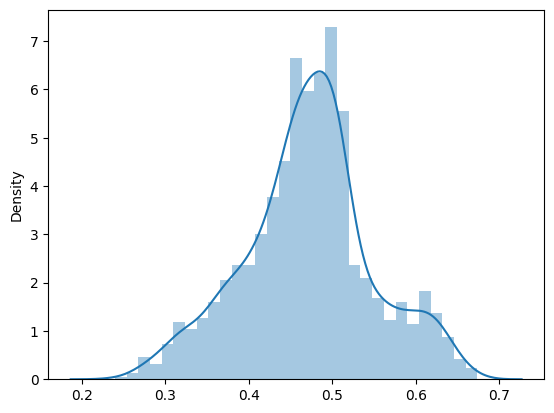

                        variable  feature_importances
15                      dp_ratio            14.173180
3            down_payment_amount             9.968436
22                 res_state_grp             7.467078
7         number_of_installments             7.414786
21                  res_city_grp             7.026048
9   res_years_at_current_address             5.629525
4                   total_income             5.024410
2                            age             4.447444
19                    branch_grp             4.299698
20               asset_model_grp             4.291469
5                occupation_type             3.667972
16              manufacturer_grp             3.665800
11                marital_status             3.528480
12            nature_of_business             3.384113
18                  industry_grp             2.995572
23       res_resident_status_grp             2.633673
8                loan_asset_cost             2.539470
1      res_years_at_current_

In [16]:
#mid_CIBIL_level: tuned
cat_features = ['product_description', 'marital_status', 'occupation_type','industry_grp',
                'res_city_grp','res_state_grp','res_resident_status_grp','branch_grp',
                'manufacturer_grp', 'gender','nature_of_business','channel_grp','asset_model_grp']
cbc_mid_CIBIL_vf = cb_model_builder2( depth = 9,
                     learning_rate = 0.022375193103931247,
                     iterations =206,
                     l2_leaf_reg = 12.032954711310595,
                     border_count = 155,
                     bagging_temperature = 0.8428035290621423,
                     random_strength = 4.234014807063696,
                     od_wait = 80,
                     auto_class_weights = "Balanced",
                     random_state = 42,
                     objective = 'Logloss',
                     cat_features = cat_features
                    )
segment = 'mid_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
CB_model_auc(X, cbc_mid_CIBIL_vf, segment)

0:	learn: 0.6926167	total: 70.1ms	remaining: 14.4s
1:	learn: 0.6922017	total: 266ms	remaining: 27.2s
2:	learn: 0.6921917	total: 363ms	remaining: 24.6s
3:	learn: 0.6915431	total: 465ms	remaining: 23.5s
4:	learn: 0.6896725	total: 717ms	remaining: 28.8s
5:	learn: 0.6891010	total: 807ms	remaining: 26.9s
6:	learn: 0.6886894	total: 905ms	remaining: 25.7s
7:	learn: 0.6879985	total: 967ms	remaining: 23.9s
8:	learn: 0.6865701	total: 1.11s	remaining: 24.3s
9:	learn: 0.6865525	total: 1.17s	remaining: 23s
10:	learn: 0.6837854	total: 1.41s	remaining: 25s
11:	learn: 0.6833600	total: 1.52s	remaining: 24.6s
12:	learn: 0.6821868	total: 1.67s	remaining: 24.7s
13:	learn: 0.6803921	total: 1.87s	remaining: 25.7s
14:	learn: 0.6798257	total: 2s	remaining: 25.4s
15:	learn: 0.6798257	total: 2.03s	remaining: 24.1s
16:	learn: 0.6790621	total: 2.17s	remaining: 24.2s
17:	learn: 0.6790621	total: 2.21s	remaining: 23.1s
18:	learn: 0.6779382	total: 2.31s	remaining: 22.7s
19:	learn: 0.6766635	total: 2.46s	remaining: 22

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_16076\1404315374.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


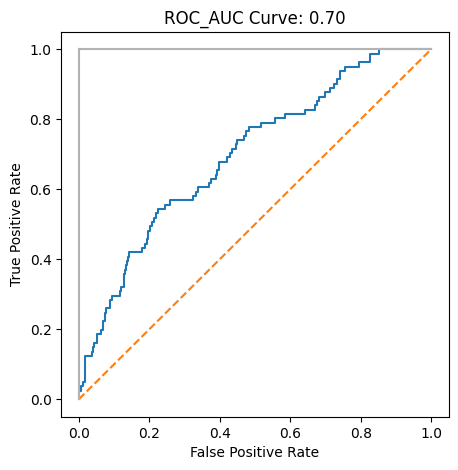

               precision    recall  f1-score   support

Good Customer       0.98      0.78      0.87      2565
 Bad Customer       0.07      0.53      0.12        81

     accuracy                           0.77      2646
    macro avg       0.53      0.65      0.50      2646
 weighted avg       0.95      0.77      0.84      2646

[[1992  573]
 [  38   43]]
1992 573 38 43


C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_16076\1404315374.py:66: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


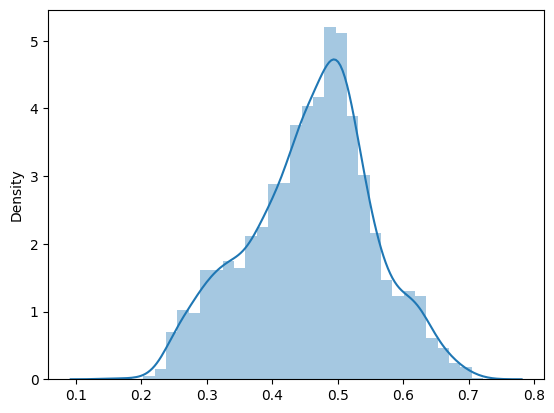

                        variable  feature_importances
3            down_payment_amount            14.538449
15                      dp_ratio            11.833850
7         number_of_installments             9.652731
23       res_resident_status_grp             7.275738
22                 res_state_grp             7.190087
21                  res_city_grp             5.224806
6                  interest_rate             5.043900
12            nature_of_business             4.512046
18                  industry_grp             4.418233
16              manufacturer_grp             4.296041
2                            age             3.625605
5                occupation_type             3.504499
11                marital_status             3.221021
1      res_years_at_current_city             2.601364
8                loan_asset_cost             2.596966
20               asset_model_grp             2.416121
4                   total_income             2.010742
14                monthly_in

In [17]:
#high_CIBIL_level: tuned
cat_features = ['product_description', 'marital_status', 'occupation_type','industry_grp',
                'res_city_grp','res_state_grp','res_resident_status_grp','branch_grp',
                'manufacturer_grp', 'gender','nature_of_business','channel_grp','asset_model_grp']
cbc_high_CIBIL_vf = cb_model_builder2( depth = 9,
                     learning_rate = 0.022375193103931247,
                     iterations =206,
                     l2_leaf_reg = 12.032954711310595,
                     border_count = 155,
                     bagging_temperature = 0.8428035290621423,
                     random_strength = 4.234014807063696,
                     od_wait = 80,
                     auto_class_weights = "Balanced",
                     random_state = 42,
                     objective = 'Logloss',
                     cat_features = cat_features
                    )
segment = 'high_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
CB_model_auc(X, cbc_high_CIBIL_vf, segment)